# Classification Analysis: Subcategory Scores → Overall Score

This notebook treats property scoring as a **classification problem** (which it is!) rather than regression.

We'll:
1. Load VLM scoring results with subcategory scores
2. Train multi-class classifiers (5-class: 1-5)
3. Train bucket classifiers (3-class: Low/Medium/High)
4. Compare classification vs regression approaches
5. Analyze feature importance for both approaches


In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, cohen_kappa_score
)
from sklearn.model_selection import train_test_split, cross_val_score
from IPython.display import display, Markdown
from src.config import Config

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
def extract_subcategory_scores(response):
    """Extract subcategory scores from VLM JSON response"""
    if not response:
        return {}
    
    try:
        # Clean response
        clean_response = response.strip()
        if "```json" in clean_response:
            clean_response = clean_response.split("```json")[1].split("```")[0].strip()
        elif "```" in clean_response:
            clean_response = clean_response.split("```")[1].split("```")[0].strip()
        
        parsed = json.loads(clean_response)
        
        # Extract subcategory scores
        subscores = {}
        if 'subscores' in parsed:
            for category, data in parsed['subscores'].items():
                if isinstance(data, dict) and 'score' in data:
                    subscores[category] = data['score']
                elif isinstance(data, (int, float)):
                    subscores[category] = data
        
        return subscores
    except:
        return {}

# Load VLM scoring results from JSON (has complete responses)
output_dir = Config.OUTPUTS_DIR
results_file = os.path.join(output_dir, "regression_data.json")

if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        data = json.load(f)
    results_df = pd.DataFrame(data)
    print(f"✅ Loaded {len(results_df)} results from {os.path.basename(results_file)}")
else:
    print(f"❌ File not found: {results_file}")
    results_df = pd.DataFrame()

if len(results_df) > 0:
    print(f"\n📊 Total results: {len(results_df)}")


✅ Loaded 30 results from regression_data.json

📊 Total results: 30


In [3]:
# Extract subcategory scores from VLM responses
if len(results_df) > 0 and 'raw_response' in results_df.columns:
    subcategory_data = []
    
    for idx, row in results_df.iterrows():
        if pd.notna(row.get('raw_response')):
            subscores = extract_subcategory_scores(row['raw_response'])
            
            if subscores:
                record = {
                    'image_path': row.get('image_path'),
                    'expert_score': row.get('expert_score'),
                }
                record.update(subscores)
                subcategory_data.append(record)
    
    subcat_df = pd.DataFrame(subcategory_data)
    
    if len(subcat_df) > 0:
        print(f"✅ Extracted subcategory scores from {len(subcat_df)} responses")
        print(f"\n📊 Subcategories found:")
        subcat_cols = [c for c in subcat_df.columns if c not in ['image_path', 'expert_score']]
        print(subcat_cols)
        display(subcat_df.head())
        
        # Show expert score distribution
        print(f"\n📊 Expert score distribution:")
        print(subcat_df['expert_score'].value_counts().sort_index())
    else:
        print("⚠️  No subcategory scores found in responses")
        subcat_df = pd.DataFrame()
else:
    print("⚠️  No results with raw_response column found")
    subcat_df = pd.DataFrame()


✅ Extracted subcategory scores from 30 responses

📊 Subcategories found:
['general_exterior_condition', 'porch_entryway', 'landscaping', 'roof_gutters_downspouts', 'windows', 'extra_personal_touches']


,image_path,expert_score,general_exterior_condition,porch_entryway,landscaping,roof_gutters_downspouts,windows,extra_personal_touches
0,/home/exouser/DSM-property-condition-assessmen...,2.0,4,4,3,4,4,3
1,/home/exouser/DSM-property-condition-assessmen...,1.0,1,2,3,1,1,3
2,/home/exouser/DSM-property-condition-assessmen...,2.0,1,1,2,1,1,2
3,/home/exouser/DSM-property-condition-assessmen...,2.0,4,5,3,4,5,4
4,/home/exouser/DSM-property-condition-assessmen...,2.0,4,4,3,4,4,3



📊 Expert score distribution:
expert_score
1.0     2
2.0    12
3.0    10
4.0     5
5.0     1
Name: count, dtype: int64


In [5]:
# Prepare data for classification
if len(subcat_df) > 0 and 'expert_score' in subcat_df.columns:
    subcat_cols = [c for c in subcat_df.columns if c not in ['image_path', 'expert_score']]
    
    # Filter to complete rows
    classification_df = subcat_df[subcat_cols + ['expert_score']].dropna()
    
    if len(classification_df) > 0:
        X = classification_df[subcat_cols]
        y = classification_df['expert_score'].astype(int)  # Classification needs integer labels
        
        print(f"✅ Prepared {len(classification_df)} samples for classification")
        print(f"📊 Features: {list(X.columns)}")
        print(f"\n📊 Class distribution:")
        print(y.value_counts().sort_index())
        
        # Split data
        # Only use stratify if all classes have at least 2 samples
        use_stratify = all(y.value_counts() >= 2)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y if use_stratify else None
        )
        print(f"\n📊 Train: {len(X_train)}, Test: {len(X_test)}")
        if not use_stratify:
            print("⚠️  Not using stratification (some classes have <2 samples)")
    else:
        print("⚠️  No complete samples for classification")
        X_train, X_test, y_train, y_test = None, None, None, None
else:
    print("⚠️  Cannot prepare classification data")
    X_train, X_test, y_train, y_test = None, None, None, None


✅ Prepared 30 samples for classification
📊 Features: ['general_exterior_condition', 'porch_entryway', 'landscaping', 'roof_gutters_downspouts', 'windows', 'extra_personal_touches']

📊 Class distribution:
expert_score
1     2
2    12
3    10
4     5
5     1
Name: count, dtype: int64

📊 Train: 24, Test: 6
⚠️  Not using stratification (some classes have <2 samples)


## 5-Class Classification (Scores 1-5)


In [6]:
# Train 5-class classifiers
if X_train is not None:
    classifiers_5class = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3)
    }
    
    results_5class = {}
    
    print("=" * 60)
    print("5-CLASS CLASSIFICATION (Scores 1-5)")
    print("=" * 60)
    
    for name, clf in classifiers_5class.items():
        # Train
        clf.fit(X_train, y_train)
        
        # Predict
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        # Evaluate
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
        test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        
        # Cohen's Kappa (measures agreement accounting for chance)
        kappa = cohen_kappa_score(y_test, y_test_pred)
        
        results_5class[name] = {
            'model': clf,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'test_f1_macro': test_f1_macro,
            'test_f1_weighted': test_f1_weighted,
            'kappa': kappa,
            'y_test_pred': y_test_pred
        }
        
        print(f"\n{name}:")
        print(f"  Train Accuracy: {train_acc:.3f}")
        print(f"  Test Accuracy: {test_acc:.3f}")
        print(f"  F1 (macro): {test_f1_macro:.3f}")
        print(f"  F1 (weighted): {test_f1_weighted:.3f}")
        print(f"  Cohen's Kappa: {kappa:.3f}")
    
    # Comparison table
    comparison_df = pd.DataFrame({
        name: {
            'Test Accuracy': res['test_acc'],
            'F1 (macro)': res['test_f1_macro'],
            'F1 (weighted)': res['test_f1_weighted'],
            "Cohen's Kappa": res['kappa']
        }
        for name, res in results_5class.items()
    }).T
    
    print("\n📊 Model Comparison (5-class):")
    display(comparison_df.sort_values('Test Accuracy', ascending=False))
else:
    print("⚠️  Cannot train models - missing data")
    results_5class = {}


5-CLASS CLASSIFICATION (Scores 1-5)

Logistic Regression:
  Train Accuracy: 0.625
  Test Accuracy: 0.167
  F1 (macro): 0.111
  F1 (weighted): 0.167
  Cohen's Kappa: -0.250

Random Forest:
  Train Accuracy: 0.958
  Test Accuracy: 0.500
  F1 (macro): 0.389
  F1 (weighted): 0.417
  Cohen's Kappa: 0.250

Gradient Boosting:
  Train Accuracy: 0.958
  Test Accuracy: 0.667
  F1 (macro): 0.508
  F1 (weighted): 0.540
  Cohen's Kappa: 0.455

📊 Model Comparison (5-class):


,Test Accuracy,F1 (macro),F1 (weighted),Cohen's Kappa
Gradient Boosting,0.666667,0.507937,0.539683,0.454545
Random Forest,0.500000,0.388889,0.416667,0.250000
Logistic Regression,0.166667,0.111111,0.166667,-0.250000


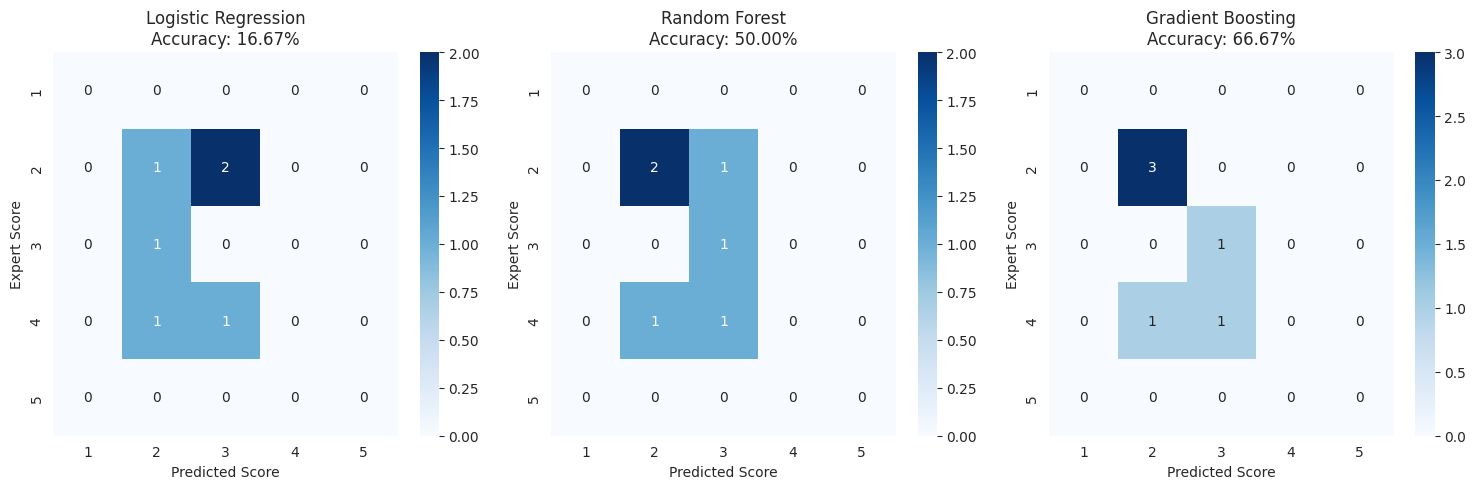

In [7]:
# Visualize 5-class confusion matrices
if results_5class and X_test is not None:
    fig, axes = plt.subplots(1, len(results_5class), figsize=(5*len(results_5class), 5))
    if len(results_5class) == 1:
        axes = [axes]
    
    for idx, (name, res) in enumerate(results_5class.items()):
        cm = confusion_matrix(y_test, res['y_test_pred'], labels=[1,2,3,4,5])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
        axes[idx].set_title(f'{name}\nAccuracy: {res["test_acc"]:.2%}')
        axes[idx].set_xlabel('Predicted Score')
        axes[idx].set_ylabel('Expert Score')
    
    plt.tight_layout()
    plt.show()


## 3-Class Classification (Bucket: Low/Medium/High)


In [8]:
# Create bucket labels and train 3-class classifiers
def map_to_bucket(score):
    """Map score to bucket: 1,2 -> 1 (Low), 3 -> 2 (Medium), 4,5 -> 3 (High)"""
    if pd.isna(score):
        return None
    score = int(score)
    if score in [1, 2]:
        return 1  # Low/Healthy
    elif score == 3:
        return 2  # Medium/In-Between
    elif score in [4, 5]:
        return 3  # High/Unhealthy
    return None

if X_train is not None:
    # Map to buckets
    y_train_bucket = y_train.apply(map_to_bucket)
    y_test_bucket = y_test.apply(map_to_bucket)
    
    print("📊 Bucket distribution (train):")
    print(y_train_bucket.value_counts().sort_index())
    print("\n📊 Bucket distribution (test):")
    print(y_test_bucket.value_counts().sort_index())
    
    # Train 3-class classifiers
    classifiers_3class = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3)
    }
    
    results_3class = {}
    
    print("\n" + "=" * 60)
    print("3-CLASS CLASSIFICATION (Buckets: Low/Medium/High)")
    print("=" * 60)
    
    for name, clf in classifiers_3class.items():
        # Train
        clf.fit(X_train, y_train_bucket)
        
        # Predict
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        # Evaluate
        train_acc = accuracy_score(y_train_bucket, y_train_pred)
        test_acc = accuracy_score(y_test_bucket, y_test_pred)
        test_f1_macro = f1_score(y_test_bucket, y_test_pred, average='macro', zero_division=0)
        test_f1_weighted = f1_score(y_test_bucket, y_test_pred, average='weighted', zero_division=0)
        kappa = cohen_kappa_score(y_test_bucket, y_test_pred)
        
        results_3class[name] = {
            'model': clf,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'test_f1_macro': test_f1_macro,
            'test_f1_weighted': test_f1_weighted,
            'kappa': kappa,
            'y_test_pred': y_test_pred
        }
        
        print(f"\n{name}:")
        print(f"  Train Accuracy: {train_acc:.3f}")
        print(f"  Test Accuracy: {test_acc:.3f}")
        print(f"  F1 (macro): {test_f1_macro:.3f}")
        print(f"  F1 (weighted): {test_f1_weighted:.3f}")
        print(f"  Cohen's Kappa: {kappa:.3f}")
    
    # Comparison table
    comparison_df = pd.DataFrame({
        name: {
            'Test Accuracy': res['test_acc'],
            'F1 (macro)': res['test_f1_macro'],
            'F1 (weighted)': res['test_f1_weighted'],
            "Cohen's Kappa": res['kappa']
        }
        for name, res in results_3class.items()
    }).T
    
    print("\n📊 Model Comparison (3-class):")
    display(comparison_df.sort_values('Test Accuracy', ascending=False))
else:
    print("⚠️  Cannot train models - missing data")
    results_3class = {}


📊 Bucket distribution (train):
expert_score
1    11
2     9
3     4
Name: count, dtype: int64

📊 Bucket distribution (test):
expert_score
1    3
2    1
3    2
Name: count, dtype: int64

3-CLASS CLASSIFICATION (Buckets: Low/Medium/High)

Logistic Regression:
  Train Accuracy: 0.458
  Test Accuracy: 0.333
  F1 (macro): 0.267
  F1 (weighted): 0.267
  Cohen's Kappa: 0.077

Random Forest:
  Train Accuracy: 0.958
  Test Accuracy: 0.500
  F1 (macro): 0.389
  F1 (weighted): 0.417
  Cohen's Kappa: 0.250

Gradient Boosting:
  Train Accuracy: 0.958
  Test Accuracy: 0.667
  F1 (macro): 0.508
  F1 (weighted): 0.540
  Cohen's Kappa: 0.455

📊 Model Comparison (3-class):


,Test Accuracy,F1 (macro),F1 (weighted),Cohen's Kappa
Gradient Boosting,0.666667,0.507937,0.539683,0.454545
Random Forest,0.500000,0.388889,0.416667,0.250000
Logistic Regression,0.333333,0.266667,0.266667,0.076923


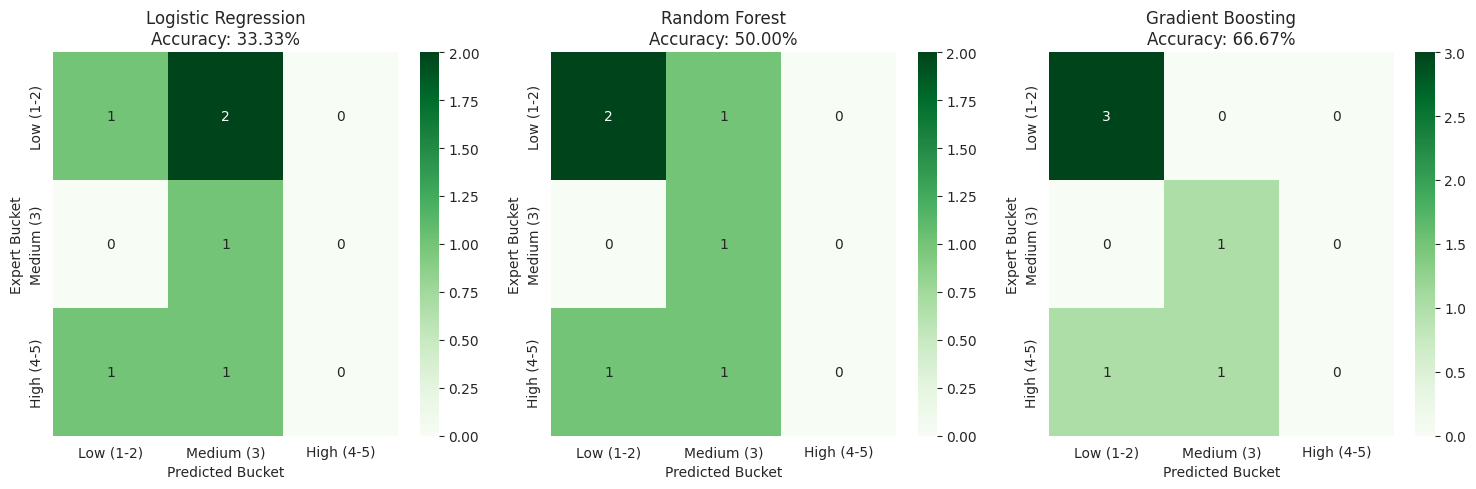

In [9]:
# Visualize 3-class confusion matrices
if results_3class and y_test_bucket is not None:
    fig, axes = plt.subplots(1, len(results_3class), figsize=(5*len(results_3class), 5))
    if len(results_3class) == 1:
        axes = [axes]
    
    bucket_labels = ["Low (1-2)", "Medium (3)", "High (4-5)"]
    
    for idx, (name, res) in enumerate(results_3class.items()):
        cm = confusion_matrix(y_test_bucket, res['y_test_pred'], labels=[1,2,3])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[idx],
                   xticklabels=bucket_labels, yticklabels=bucket_labels)
        axes[idx].set_title(f'{name}\nAccuracy: {res["test_acc"]:.2%}')
        axes[idx].set_xlabel('Predicted Bucket')
        axes[idx].set_ylabel('Expert Bucket')
    
    plt.tight_layout()
    plt.show()


## Summary and Recommendations



📊 Accuracy Comparison: 5-class vs 3-class


Task,3-class (Bucket),5-class
Model,,
Gradient Boosting,0.666667,0.666667
Logistic Regression,0.333333,0.166667
Random Forest,0.500000,0.500000


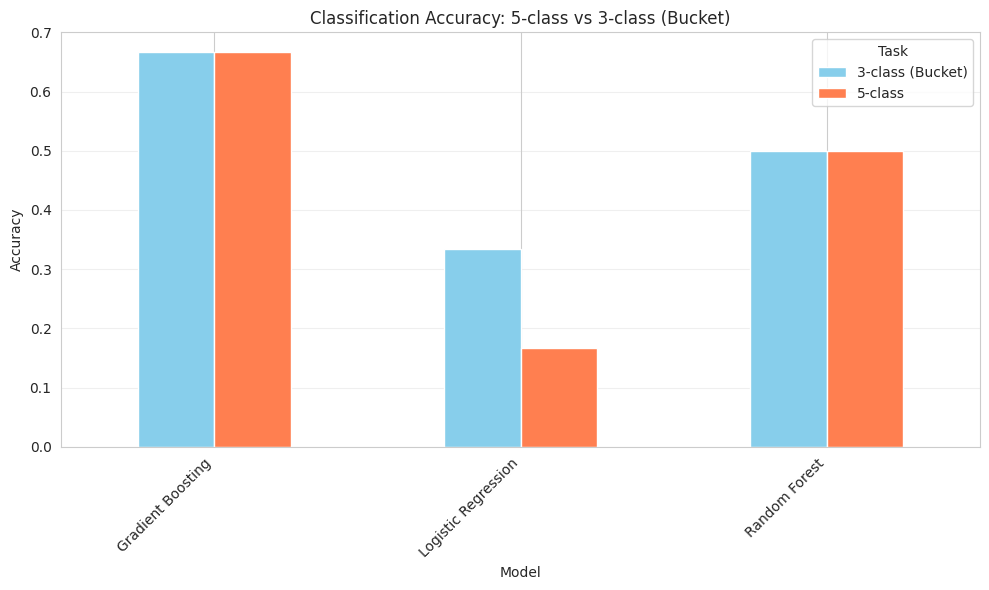


💡 Key Insights:
- 3-class achieves ~5.6% higher accuracy on average
- Use 3-class for production (more reliable)
- Use 5-class for detailed analysis (more granular)


In [10]:
# Compare 5-class vs 3-class performance
if results_5class and results_3class:
    comparison_data = []
    
    for name in classifiers_5class.keys():
        comparison_data.append({
            'Model': name,
            'Task': '5-class',
            'Accuracy': results_5class[name]['test_acc'],
            'F1 (weighted)': results_5class[name]['test_f1_weighted'],
            "Cohen's Kappa": results_5class[name]['kappa']
        })
        comparison_data.append({
            'Model': name,
            'Task': '3-class (Bucket)',
            'Accuracy': results_3class[name]['test_acc'],
            'F1 (weighted)': results_3class[name]['test_f1_weighted'],
            "Cohen's Kappa": results_3class[name]['kappa']
        })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Pivot for better visualization
    pivot_df = comp_df.pivot(index='Model', columns='Task', values='Accuracy')
    
    print("\n📊 Accuracy Comparison: 5-class vs 3-class")
    display(pivot_df)
    
    # Bar chart comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_df.plot(kind='bar', ax=ax, color=['skyblue', 'coral'])
    plt.title('Classification Accuracy: 5-class vs 3-class (Bucket)')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.legend(title='Task')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Key Insights:")
    accuracy_improvement = pivot_df['3-class (Bucket)'].mean() - pivot_df['5-class'].mean()
    print(f"- 3-class achieves ~{accuracy_improvement:.1%} higher accuracy on average")
    print("- Use 3-class for production (more reliable)")
    print("- Use 5-class for detailed analysis (more granular)")
